# Questions to answer
- What is the best investment frequency (i.e. how often should I invest)?
- How much value can I expect my portfolio to be worth after 25 years?
- What is the minimum/maximum value of my portfolio after any given 25-year period?
- What final value will my portfolio have in 95% of the cases in any given 25-year period?
- What 25-year periods produced the best/worst results?

# Code for simulation
The following cells contains the code for running the simulation

In [5]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from math import floor
from scipy.stats import norm
from datetime import datetime, timedelta

## Create function for simulating saving for n years

In [6]:
def save_for_n_years_df(df, start_date, end_date, dca_monthly_investment_amount, dca_investment_frequency_per_month):
    
    df = df[df['Date'] < end_date]
    df = df[df['Date'] >= start_date]
    df = df.set_index(pd.DatetimeIndex(df['Date'])).resample(f"{floor(30 / dca_investment_frequency_per_month)}D").agg('first')
    period_last_open = df.iloc[-1]['Open']
    df['added_capital'] = dca_monthly_investment_amount / dca_investment_frequency_per_month
    df['value_period_end'] = df['added_capital'] * (period_last_open / df['Open'])
    return {"start_date": df.iloc[0]['Date'], "end_date": df.iloc[-1]['Date'], "investment_frequency": floor(30 / dca_investment_frequency_per_month), "value": df['value_period_end'].sum()}

## Set simulation parameters

In [10]:
#From what date we will start run our simulations
simulation_start_date = datetime(1927, 12, 30)

#Until what date we will run our simulations
simulation_end_date = datetime(1928, 12, 31)

#What investment frequencies to test - 4/month, 2/month and 1/month
investment_frequencies_per_month = [4, 2, 1, 30/60]

#How much will we invest each month
monthly_investment_amount = 10000

#Investment horizon, i.e. how many years we will save for
investment_horizon = 25

#Read file containing S&P500 historical data
file = r'data/SPX.csv'
df = pd.read_csv(file, index_col=None, header=0)

#Date column is String, convert to Python Datetime
df['Date'] = pd.to_datetime(df['Date'])

#Results will go here
result = []

## Start simulation

In [11]:
#Loop through each investment frequency
for investment_frequency_per_month in investment_frequencies_per_month:
    
    #Set current date to our simulation start date
    simulation_current_date = simulation_start_date
    
    print(f"Testing investment frequency of {floor(30 / investment_frequency_per_month)} days")

    #Simulate starting investing
    while simulation_current_date < simulation_end_date:
    
        #Save result - Start date, end date, current frequency and value
        result.append(save_for_n_years_df(df, simulation_current_date, simulation_current_date + timedelta(days=365*investment_horizon), monthly_investment_amount, investment_frequency_per_month))
    
        #Start simulating from 
        simulation_current_date = simulation_current_date + timedelta(days=1)
    
#Convert results to df
results_df = pd.DataFrame(result)

Testing investment frequency of 7 days
Testing investment frequency of 15 days
Testing investment frequency of 30 days
Testing investment frequency of 60 days


# Results
<p> These are the results after running a simulation where a person invests n SEK for y years

## What is the best investment frequency (i.e. how often should I invest)?
<p> What is the best frequency for investing your money? Once a month? Twice a month? Or perhaps more seldom? </p>

In [12]:
#Group result by investment frequency
results_df.groupby('investment_frequency').agg({'value' : ['mean', 'min', 'max', 'median']})

value                                          
                              mean           min           max        median
investment_frequency                                                        
7                     6.191325e+06  5.667450e+06  6.683085e+06  6.157920e+06
15                    5.786248e+06  5.298005e+06  6.239944e+06  5.757065e+06
30                    5.791814e+06  5.305179e+06  6.240667e+06  5.766355e+06
60                    5.803698e+06  5.285956e+06  6.257794e+06  5.772346e+06

### How much difference is there between the best and the worst investment frequency?
<p>How large is the difference in wealth when using the best vs the worst investment frequency?</p>

0.39555766300727574

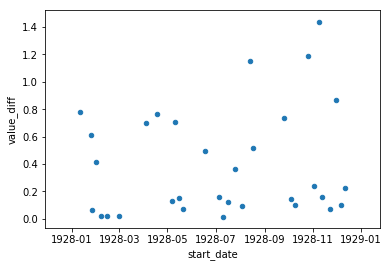

In [13]:
def percentage_change(col1, col2):
    return ((col1 - col2)/col2) * 100

portfolio_diff_min_max_frequency = results_df.drop_duplicates(subset=['start_date', 'end_date', 'investment_frequency'])
portfolio_diff_min_max_frequency = portfolio_diff_min_max_frequency.loc[(portfolio_diff_min_max_frequency['investment_frequency'] == 7) | (portfolio_diff_min_max_frequency['investment_frequency'] == 60)]
portfolio_diff_min_max_frequency = portfolio_diff_min_max_frequency.sort_values(by=['start_date'])
portfolio_diff_min_max_frequency['value_diff'] = percentage_change(portfolio_diff_min_max_frequency['value'], portfolio_diff_min_max_frequency['value'].shift(1).fillna(portfolio_diff_min_max_frequency['value']))
portfolio_diff_min_max_frequency = portfolio_diff_min_max_frequency[(portfolio_diff_min_max_frequency['investment_frequency'] == 60) & (portfolio_diff_min_max_frequency['value_diff'] > 0)]
portfolio_diff_min_max_frequency.plot(kind='scatter', x='start_date', y='value_diff')
portfolio_diff_min_max_frequency['value_diff'].mean()

## How much value can I expect my portfolio to be worth after 25 years?

#### Histogram with 95% confidence interval for our best investment frequency
<p>The graph below plots the results in our best investment frequency scenario and shows the 95% confidence interval for it - This means that in 95% of cases you can expect to end up with this amount of money after 25 years of saving with the selected investment frequency.</p>

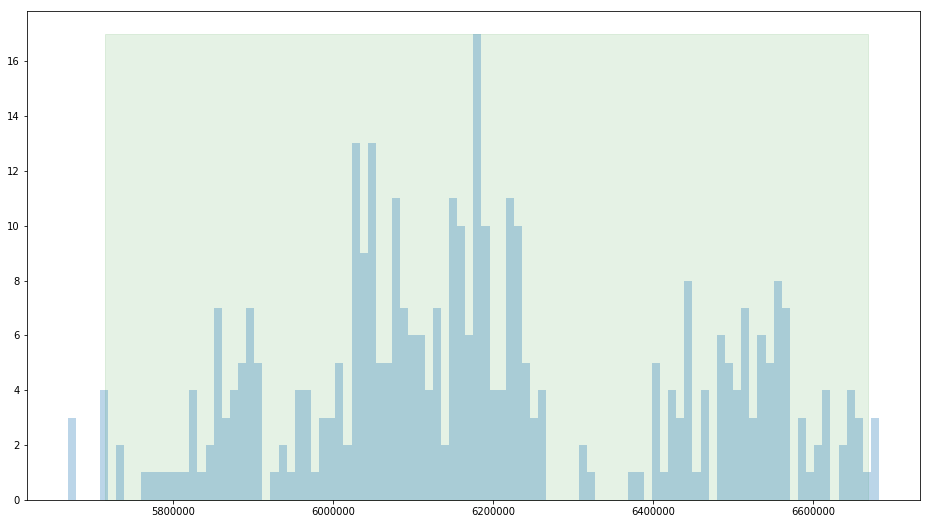

In [16]:
test_df = results_df[results_df['investment_frequency'] == 7]
arr = test_df['value']
plt.figure(figsize=(16,9))
ci = norm(*norm.fit(arr)).interval(0.95)  # fit a normal distribution and get 95% c.i.
height, bins, patches = plt.hist(arr, alpha=0.3, bins=100)
plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.1)

## What 25-year periods produced the best/worst results?

In [33]:
#Find the best frequency for investing
results_df.sort_values(by=['value'], ascending=False)
results_df.head()

,start_date,end_date,investment_frequency,value
1371,1928-09-25,1953-09-14,60,5.285956e+06
637,1928-09-25,1953-09-14,15,5.298005e+06
635,1928-09-24,1953-09-14,15,5.299178e+06
634,1928-09-24,1953-09-14,15,5.299178e+06
636,1928-09-24,1953-09-14,15,5.299178e+06


In [30]:
#Find the worst frequency for investing
#results_df.sort_values(by=['value'], ascending=True)
results_df.tail()

,start_date,end_date,investment_frequency,value
12,1928-01-11,1952-12-31,7,6.656314e+06
11,1928-01-10,1952-12-30,7,6.665448e+06
15,1928-01-16,1953-01-05,7,6.683085e+06
17,1928-01-16,1953-01-05,7,6.683085e+06
16,1928-01-16,1953-01-05,7,6.683085e+06


# TODO: Combine investment frequency with simulation start dates
<p>Shorter investment frequencies might produce superior results just because they happened to be in a strong bull market (such as 1927, 1997 and 2006). It is possible that this gain would be offset in the aftercoming bust however, but I'm not sure. It would be nice to see if a majority of superior investment frequencies happened to be clustered around certain start dates.</p>

In [ ]:
fig, ax = plt.subplots(figsize=(64,32))
for key, grp in results_df.groupby(['investment_frequency']):
    ax = grp.plot(ax=ax, kind='line', x='start_date', y='value', label=key)
    
df[df['Date'] <= results_df['end_date'].max()].plot(x='Date', y='Open', figsize=(64,32))
plt.fill_betweenx([0, 3500], results_df['start_date'].min(), results_df['start_date'].max(), color='g', alpha=0.1)
plt.show()

<p>It seems as if choosing a shorter investment frequency we will end up with more money no matter if we are in a bull or bear market.
This graph also shows that if we were to invest in late 1930 our portfolio would be worth around 10 millions after 25 year, no matter what investment frequency we chose. However, if we were to invest in late 1928 (at the peak of the Roaring 20's boom) our portfolio would be worth "only" ~6 millions after 25 years.
</p>